<a href="https://colab.research.google.com/github/danglive/Deep-Learning-tutorial/blob/master/%20GDP%20per%20capita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Package Setup
!pip install -qU plotly daft torchtext
!git clone -q https://github.com/uber/pyro.git
!cd pyro; git checkout -q dev; pip install -q .
!rm -fr start; git clone --single-branch -b demos2018 -q https://github.com/harvard-ml-courses/cs281-demos start; cp -f start/cs281.py cs281.py
!wget -q "https://github.com/harvardnlp/LatentVariableNLP/blob/master/data/yahoo/val.txt?raw=true"
!mv "val.txt?raw=true" val.txt

     |████████████████████████████████| 7.2MB 8.6MB/s 
     |████████████████████████████████| 61kB 26.4MB/s 
     \ 20kB 231kB/s
     |████████████████████████████████| 61kB 7.3MB/s 


In [0]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.4.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

##Dataset

In [0]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

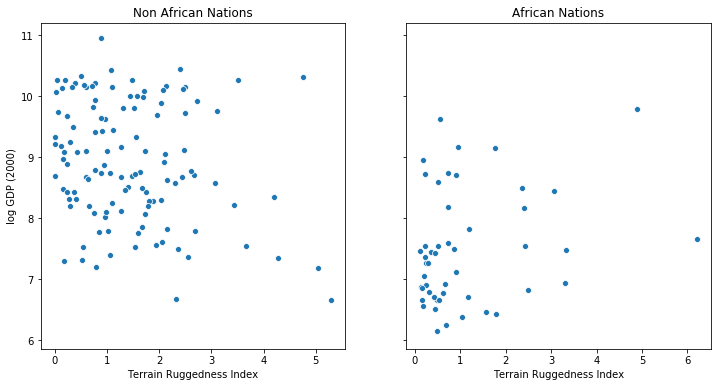

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = data[data["cont_africa"] == 1]
non_african_nations = data[data["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            np.log(non_african_nations["rgdppc_2000"]),
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
            np.log(african_nations["rgdppc_2000"]),
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

Linear Regression

We would like to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index. Let’s define our regression model. We’ll use PyTorch’s nn.Module for this. Our input X is a matrix of size N×2 and our output y is a vector of size 2×1. The function nn.Linear(p, 1) defines a linear transformation of the form Xw+b where w is the weight matrix and b is the additive bias. We include an extra self.factor term meant to capture the correlation between ruggedness and whether a country is in Africa.

Note that we can easily make this a logistic regression by adding a non-linearity in the forward() method.

In [0]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)
        self.factor = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.linear(x) + (self.factor * x[:, 0] * x[:, 1]).unsqueeze(1)

p = 2  # number of features
regression_model = RegressionModel(p)

##Training

We will use the mean squared error (MSE) as our loss and Adam as our optimizer. We would like to optimize the parameters of the regression_model neural net above. We will use a somewhat large learning rate of 0.05 and run for 500 iterations.

In [7]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(regression_model.parameters(), lr=0.05)
num_iterations = 1000 if not smoke_test else 2
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

def main():
    x_data = data[:, :-1]
    y_data = data[:, -1]
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = regression_model(x_data).squeeze(-1)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in regression_model.named_parameters():
        print(name, param.data.numpy())

main()

[iteration 0050] loss: 3723.7849
[iteration 0100] loss: 1777.9850
[iteration 0150] loss: 1226.7540
[iteration 0200] loss: 927.1512
[iteration 0250] loss: 706.6472
[iteration 0300] loss: 536.0910
[iteration 0350] loss: 408.0939
[iteration 0400] loss: 316.1810
[iteration 0450] loss: 252.9710
[iteration 0500] loss: 211.2545
[iteration 0550] loss: 184.7950
[iteration 0600] loss: 168.6502
[iteration 0650] loss: 159.1673
[iteration 0700] loss: 153.8036
[iteration 0750] loss: 150.8815
[iteration 0800] loss: 149.3482
[iteration 0850] loss: 148.5732
[iteration 0900] loss: 148.1960
[iteration 0950] loss: 148.0193
[iteration 1000] loss: 147.9397
Learned parameters:
factor 0.37248382
linear.weight [[-1.90511    -0.18619268]]
linear.bias [9.188872]


##Bayesian Regression